# EDA 및 모델 돌리기

In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from lightgbm import LGBMRegressor, early_stopping, log_evaluation

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.preprocessing import MinMaxScaler
#standardscaler
from sklearn.preprocessing import StandardScaler
#robustscaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import StratifiedKFold

In [3]:
#샘플 데이터 불러오기
whole = pd.read_csv("./../../Datas/updated_df2(knn).csv")

In [4]:
#data concat

# 살릴 column들 정리
use_cols = np.array(['전용면적', '계약년월', '층','거래유형', 'k-전체동수',
'k-전체세대수', 'k-연면적', '주차대수', 'lat', 'long', 'target', 
'시군구', '아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)',
'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-홈페이지',
'is_test', '학군', '오마카세', '한강변', '신축여부', '건물연식'
])


df = whole[use_cols]

df['구'] = df['시군구'].str.split(' ').str[1]
df['동'] = df['시군구'].str.split(' ').str[1] + ' ' + df['시군구'].str.split(' ').str[2]
df_train = df[df['is_test'] == 0]
df_test = df[df['is_test'] == 1]
df_train.drop(columns=['is_test'], inplace=True)
df_test.drop(columns=['is_test', 'target'], inplace=True)


### 대장아파트 거리 구해보기

In [5]:
# 지역구별 대장 아파트들을 입력합니다.
lead_house = {
    "강서구" : (37.56520754904415, 126.82349451366355),
    "관악구" : (37.47800896704934, 126.94178722423047),
    "강남구" : (37.530594054209146, 127.0262701317293),
    "강동구" : (37.557175745977375, 127.16359581113558),
    "광진구" : (37.543083184171, 127.0998363490422),
    "구로구" : (37.51045944660659, 126.88687199829572),
    "금천구" : (37.459818907487936, 126.89741481874103),
    "노원구" : (37.63952738902813, 127.07234254197617),
    "도봉구" : (37.65775043994647, 127.04345013224447),
    "동대문구" : (37.57760781415707, 127.05375628992316),
    "동작구" : (37.509881249641495, 126.9618159122961),
    "마포구" : (37.54341664563958, 126.93601641235335),
    "서대문구" : (37.55808950436837, 126.9559315685538),
    "서초구" : (37.50625410912666, 126.99846468032919),
    "성동구" : (37.53870643389788, 127.04496220606433),
    "성북구" : (37.61158435092128, 127.02699796439015),
    "송파구" : (37.512817775046074, 127.08340371063358),
    "양천구" : (37.526754982736556, 126.86618704123521),
    "영등포구" : (37.52071403351804, 126.93668907644046),
    "용산구" : (37.521223570097305, 126.97345317787784),
    "은평구" : (37.60181702377437, 126.9362806808709),
    "종로구" : (37.56856915384472, 126.96687674967252),
    "중구" : (37.5544678205846, 126.9634879236162),
    "중랑구" : (37.58171824083332, 127.08183326205129),
    "강북구" : (37.61186335979484, 127.02822407466175)
}


In [6]:
# 위경도를 이용해 두 지점간의 거리를 구하는 함수를 생성합니다.
import math
def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = radius * c
    return distance

In [7]:
# 대장 아파트의 위경도 데이터프레임을 구성합니다.
lead_house_data = pd.DataFrame([{"구": k, "대장_좌표X": v[1], "대장_좌표Y": v[0]} for k, v in lead_house.items()])
# 데이터프레임간 결합을 합니다.
df_train = pd.merge(df_train, lead_house_data, how="inner", on="구")
df_test = pd.merge(df_test, lead_house_data, how="inner", on="구")

# 아까 제작한 haversine_distance 함수를 이용해 대장아파트와의 거리를 계산하고, 새롭게 컬럼을 구성합니다.
df_train['대장아파트_거리'] = df_train.apply(lambda row: haversine_distance(row["lat"], row["long"], row["대장_좌표Y"], row["대장_좌표X"]), axis=1)
df_test['대장아파트_거리'] = df_test.apply(lambda row: haversine_distance(row["lat"], row["long"], row["대장_좌표Y"], row["대장_좌표X"]), axis=1)
df_train.drop(columns=['대장_좌표X', '대장_좌표Y'], inplace=True)
df_test.drop(columns=['대장_좌표X', '대장_좌표Y'], inplace=True)


### 

In [8]:
# from math import radians, sin, cos, sqrt, atan2
# # Haversine 거리 계산 함수
# def haversine(lat1, lon1, lat2, lon2):
#     R = 6371  # 지구 반지름 (km)
#     lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))
#     return R * c

In [9]:
# train_apts = df_train[['아파트명', 'lat', 'long']].drop_duplicates()
# test_apts  = df_test[['아파트명', 'lat', 'long']].drop_duplicates()

# # 테스트셋에서 학습셋에 없는 아파트명만 추출
# unknown_apts = test_apts[~test_apts['아파트명'].isin(train_apts['아파트명'])]


In [10]:
# apt_name_mapping = {}
# for i, test_row in unknown_apts.iterrows():
#     test_name = test_row['아파트명']
#     test_lat, test_lon = test_row['lat'], test_row['long']
    
#     min_dist = float('inf')
#     closest_name = None
#     for j, train_row in train_apts.iterrows():
#         train_name = train_row['아파트명']
#         train_lat, train_lon = train_row['lat'], train_row['long']
#         dist = haversine(test_lat, test_lon, train_lat, train_lon)
#         if dist < min_dist:
#             min_dist = dist
#             closest_name = train_name
    
#     apt_name_mapping[test_name] = closest_name
# df_test['아파트명'] = df_test['아파트명'].replace(apt_name_mapping)


### StratifiedKFold 실험

In [11]:
# 계약년월 formatting
def str_to_datetime(df: pd.DataFrame, col: str) -> pd.DataFrame:
    # 문자열에서 특수문자 제거('-')
    df[col] = df[col].astype(str).str.replace('-', '')
    # 문자열을 datetime으로 변환
    df[col] = pd.to_datetime(df[col], format='%Y%m')
    df[col] = df[col].dt.strftime('%Y-%m')
    return df
    

In [12]:
# target encoding 함수
def target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str, encode_col: str, 
                   alpha: float = 0.5, global_mean: float = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()
    
    # 전체 평균 계산
    if global_mean is None:
        global_mean = df_train[target_col].mean()
    
    # 카테고리별 통계 계산
    category_stats = df_train.groupby(encode_col).agg({
        target_col: ['count', 'mean']
    }).reset_index()
    
    category_stats.columns = [encode_col, 'count', 'mean']
    
    # # 스무딩 적용
    # category_stats['smoothed_mean'] = (
    #     (category_stats['count'] * category_stats['mean'] + alpha * global_mean) / 
    #     (category_stats['count'] + alpha)
    # )
    
    # 인코딩 적용
    encoding_map = dict(zip(category_stats[encode_col], category_stats['mean']))
    
    # 학습 데이터에 적용
    df_encoded_train[f'{encode_col}_target'] = df_encoded_train[encode_col].map(encoding_map)
    
    # 테스트 데이터에 적용 (학습 데이터에 없는 카테고리는 전체 평균 사용)
    df_encoded_test[f'{encode_col}_target'] = df_encoded_test[encode_col].map(encoding_map)
    df_encoded_test[f'{encode_col}_target'].fillna(global_mean, inplace=True)
    
    return df_encoded_train, df_encoded_test
    

In [13]:
# 동 target encoding 함수
def dong_target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()
    df_gu_dong = df_encoded_train.groupby(['구', '동'])[target_col].mean().reset_index()
    df_gu = df_encoded_train.groupby('구')[target_col].mean().reset_index()
    df_gu.columns = ['구', '구_target']
    df_gu_dong = df_gu_dong.merge(df_gu, on='구', how='left')
    df_gu_dong['동_target'] = df_gu_dong[target_col] / df_gu_dong['구_target']
    

    encoding_map = dict(zip(df_gu_dong['동'], df_gu_dong['동_target']))

    df_encoded_train['동_target'] = df_encoded_train['동'].map(encoding_map)
    df_encoded_test['동_target'] = df_encoded_test['동'].map(encoding_map)

    # 테스트 데이터 결측치 채울 때 구 평균 사용
    df_encoded_test['동_target'].fillna(1, inplace=True)

    return df_encoded_train, df_encoded_test

In [14]:
# 아파트명 target encoding 함수
def apartment_target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str, alpha: float = 0.5) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()

    # 아파트명 면적당가격
    df_cost_area = df_encoded_train.groupby(['아파트명', '구', '동'])[['전용면적', target_col]].agg(['count', 'mean']).reset_index()
    df_cost_area.columns = ['아파트명', '구', '동', '_', 'area_mean', 'count', 'target_mean']
    df_cost_area['면적당가격'] = df_cost_area['target_mean'] / df_cost_area['area_mean']

    # 구 면적당가격
    df_gu = df_encoded_train.groupby('구')[['전용면적', target_col]].mean().reset_index()
    df_gu['면적당가격'] = df_gu[target_col] / df_gu['전용면적']

    # 구 면적당가격 매핑
    gu_encoding_map = dict(zip(df_gu['구'], df_gu['면적당가격']))
    df_cost_area['구_면적당가격'] = df_cost_area['구'].map(gu_encoding_map)

    df_cost_area['면적당가격_smoothed'] = (
        (df_cost_area['면적당가격'] * df_cost_area['count'] + alpha * df_cost_area['구_면적당가격']) / 
        (df_cost_area['count'] + alpha)
    )
    

    # 동 면적당가격 
    df_dong = df_encoded_train.groupby('동')[['전용면적', target_col]].mean().reset_index()
    df_dong['면적당가격'] = df_dong[target_col] / df_dong['전용면적']

    # 동 면적당가격 매핑
    dong_encoding_map = dict(zip(df_dong['동'], df_dong['면적당가격']))
    df_cost_area['동_면적당가격'] = df_cost_area['동'].map(dong_encoding_map)

    # 테스트 데이터 결측치 채울 때 동 면적당가격 혹은 구 면적당가격으로 채우기
    df_encoded_test['동_면적당가격'] = df_encoded_test['동'].map(dong_encoding_map)
    df_encoded_test['구_면적당가격'] = df_encoded_test['구'].map(gu_encoding_map)

    # 아파트명 면적당가격 매핑
    df_encoding_map = dict(zip(df_cost_area['아파트명'], df_cost_area['면적당가격_smoothed']))
    df_encoded_train['아파트명_면적당가격'] = df_encoded_train['아파트명'].map(df_encoding_map)
    df_encoded_test['아파트명_면적당가격'] = df_encoded_test['아파트명'].map(df_encoding_map)
    df_encoded_test['아파트명_면적당가격'].fillna(df_encoded_test['동_면적당가격'], inplace=True)
    df_encoded_test['아파트명_면적당가격'].fillna(df_encoded_test['구_면적당가격'], inplace=True)
    df_encoded_test.drop(columns=['동_면적당가격', '구_면적당가격'], inplace=True)

    df_encoded_train.drop(columns=['아파트명', '구', '동', '시군구'], inplace=True)
    df_encoded_test.drop(columns=['아파트명', '구', '동', '시군구'], inplace=True)
    return df_encoded_train, df_encoded_test


In [15]:
# # 아파트 면적당 가격, 구 면적당 가격  함수
# def apartment_target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str, alpha: float = 0.5) -> tuple[pd.DataFrame, pd.DataFrame]:
#     df_encoded_train = df_train.copy()
#     df_encoded_test = df_test.copy()

#     # 아파트명 면적당가격
#     df_cost_area = df_encoded_train.groupby(['아파트명', '구', '동'])[['전용면적', target_col]].agg(['count', 'mean']).reset_index()
#     df_cost_area.columns = ['아파트명', '구', '동', '_', 'area_mean', 'count', 'target_mean']
#     df_cost_area['면적당가격'] = df_cost_area['target_mean'] / df_cost_area['area_mean']
    
#     # 구 면적당가격
#     df_gu = df_encoded_train.groupby('구')[['전용면적', target_col]].mean().reset_index()
#     df_gu['면적당가격'] = df_gu[target_col] / df_gu['전용면적']

#     # 구 면적당가격 매핑
#     gu_encoding_map = dict(zip(df_gu['구'], df_gu['면적당가격']))
#     df_cost_area['구_면적당가격'] = df_cost_area['구'].map(gu_encoding_map)

#     df_cost_area['면적당가격_smoothed'] = (
#         (df_cost_area['면적당가격'] * df_cost_area['count'] + alpha * df_cost_area['구_면적당가격']) / 
#         (df_cost_area['count'] + alpha)
#     )
    

#     # 동 면적당가격 
#     df_dong = df_encoded_train.groupby('동')[['전용면적', target_col]].mean().reset_index()
#     df_dong['면적당가격'] = df_dong[target_col] / df_dong['전용면적']

#     # 동 면적당가격 매핑
#     dong_encoding_map = dict(zip(df_dong['동'], df_dong['면적당가격']))
#     df_cost_area['동_면적당가격'] = df_cost_area['동'].map(dong_encoding_map)

    
    

#     # 아파트명 면적당가격 매핑
#     df_encoding_map = dict(zip(df_cost_area['아파트명'], df_cost_area['면적당가격']))

#     df_encoded_train['아파트명_면적당가격'] = df_encoded_train['아파트명'].map(df_encoding_map)
#     df_encoded_train['구_면적당가격'] = df_encoded_train['구'].map(gu_encoding_map)
#     df_encoded_test['아파트명_면적당가격'] = df_encoded_test['아파트명'].map(df_encoding_map)
#     df_encoded_test['구_면적당가격'] = df_encoded_test['구'].map(gu_encoding_map)

#     # 테스트 데이터 결측치 채울 때 동 면적당가격 혹은 구 면적당가격으로 채우기
#     df_encoded_test['동_면적당가격'] = df_encoded_test['동'].map(dong_encoding_map)
#     df_encoded_test['아파트명_면적당가격'].fillna(df_encoded_test['동_면적당가격'], inplace=True)
#     df_encoded_test['아파트명_면적당가격'].fillna(df_encoded_test['구_면적당가격'], inplace=True)
#     df_encoded_test.drop(columns=['동_면적당가격'], inplace=True)

#     df_encoded_train.drop(columns=['아파트명', '구', '동', '시군구'], inplace=True)
#     df_encoded_test.drop(columns=['아파트명', '구', '동', '시군구'], inplace=True)
#     return df_encoded_train, df_encoded_test


In [16]:
# 라벨 인코딩 함수
def label_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    dt_train = df_train.copy()
    dt_test = df_test.copy()
    categorical_features = dt_train.select_dtypes(include=[np.object]).columns

    # 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
    label_encoders = {}

    # Implement Label Encoding
    for col in tqdm( categorical_features ):
        # 모든 고유값 수집 (학습 + 테스트)

        # 모든 고유값 수집 (학습 + 테스트)
        all_unique_values = pd.concat([dt_train[col], dt_test[col]]).unique()
        
        # 레이블 인코더 생성 및 학습
        lbl = LabelEncoder()
        lbl.fit(all_unique_values.astype(str))  # 문자열로 변환
        
        # 변환
        dt_train[col] = lbl.transform(dt_train[col].astype(str))
        dt_test[col] = lbl.transform(dt_test[col].astype(str))
        
        label_encoders[col] = lbl
    return dt_train, dt_test, label_encoders

In [17]:
# 적은 데이터를 중복 샘플링하는 함수(K-fold 실험을 위해)
from collections import Counter

def replicate_rare_samples(df, col, n_splits):
    counts = df[col].value_counts()
    dfs = [df]
    for val, cnt in counts.items():
        if cnt < n_splits:
            need = n_splits - cnt
            extra = df[df[col] == val].sample(need, replace=True, random_state=42)
            dfs.append(extra)
    return pd.concat(dfs, ignore_index=True)

In [18]:
# 계약년월 2017년 전후 트렌드로 encoidng 하는 함수
from sklearn.linear_model import LinearRegression

def contract_encoding(df_train:pd.DataFrame, df_test:pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
  df_train_copy = df_train.copy()
  df_test_copy = df_test.copy()

  df_train_copy = str_to_datetime(df_train_copy, '계약년월')
  df_test_copy = str_to_datetime(df_test_copy, '계약년월')

  df_time_check = df_train_copy.groupby('계약년월')['target'].mean().reset_index()
  df_time_check.sort_values(by='계약년월', inplace=True)
  df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월']).dt.strftime('%Y-%m')
  
  # 계약년월을 datetime으로 변환
  df_time_check['계약년월'] = pd.to_datetime(df_time_check['계약년월'])
  df_time_check = df_time_check.sort_values('계약년월').reset_index(drop=True)
  df_time_check['연도'] = df_time_check['계약년월'].dt.year

  # 2017년 기준으로 데이터 나누기
  df_before_2017 = df_time_check[df_time_check['연도'] < 2017].copy()
  df_after_2017 = df_time_check[df_time_check['연도'] >= 2017].copy()

  # 인코딩 맵 저장용 dict
  encoding_map = {}


  # 인코딩 값 생성
  def trend_encode(df, label):
      if len(df) < 2:
          return None
      n = len(df)
      y_start = df['target'].values[:3].mean()
      x = np.arange(n).reshape(-1, 1)
      y = df['target'].values.reshape(-1, 1)
      model = LinearRegression().fit(x, y)
      y_end = model.predict([[n - 1]])[0][0]
      y_trend = np.linspace(y_start, y_end, n)

      # 인코딩 맵에 저장
      for i, dt in enumerate(df['계약년월']):
          ym_str = dt.strftime('%Y-%m')
          encoding_map[ym_str] = y_trend[i]

      return model, y_start, n

  # 각 구간별 추세선 및 인코딩
  model_before, _, _ = trend_encode(df_before_2017, '2017년 이전 추세')
  model_after, y_start_after, n_after = trend_encode(df_after_2017, '2017년 이후 추세')

  # === 3개월 미래 예측 ===
  future_months = 3
  last_date = df_after_2017['계약년월'].max()

  for i in range(1, future_months + 1):
      future_date = last_date + pd.DateOffset(months=i)
      x_future = np.array([[n_after - 1 + i]])
      y_future = model_after.predict(x_future)[0][0]
      encoding_map[future_date.strftime('%Y-%m')] = y_future

  df_train_copy['계약년월'] = df_train_copy['계약년월'].map(encoding_map)
  df_test_copy['계약년월'] = df_test_copy['계약년월'].map(encoding_map)

  return df_train_copy, df_test_copy


In [19]:
# def areaPerone(df_train:pd.DataFrame, df_test:pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
#   df_train_copy = df_train.copy()
#   df_test_copy = df_test.copy()
#   df_train_copy['areaPerOne'] = df_train_copy['k-연면적'] / df_train_copy['k-전체세대수'].replace(0, np.nan)
#   df_test_copy['areaPerOne'] = df_test_copy['k-연면적'] / df_test_copy['k-전체세대수'].replace(0, np.nan)
#   df_train_copy['areaPerOne'] = df_train_copy['areaPerOne'].fillna(df_train_copy['areaPerOne'].median())
#   df_test_copy['areaPerOne'] = df_test_copy['areaPerOne'].fillna(df_test_copy['areaPerOne'].median())
#   return df_train_copy, df_test_copy

In [20]:
df_train['target_bin'] = pd.qcut(df['target'], q=10, labels = False)
df_train['target_bin']

0          9.0
1          9.0
2          8.0
3          9.0
4          9.0
          ... 
1118817    0.0
1118818    0.0
1118819    1.0
1118820    2.0
1118821    0.0
Name: target_bin, Length: 1118822, dtype: float64

In [21]:
#RandomForest
k = 5

# # 동 데이터 중 빈도수가 적은 데이터를 중복 샘플링(K-fold 실험을 위해)
# df_train = replicate_rare_samples(df_train, '동', 2)

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

rmse_scores = []
train_rmse_scores = []  # train RMSE를 저장할 리스트 추가
models = []




for fold, (train_index, valid_index) in enumerate(skf.split(df_train, df_train['target_bin'])):
    print(f'Fold {fold+1} : {len(train_index)} / {len(valid_index)}')
    train_df = df_train.iloc[train_index].drop(columns=['target_bin'])
    valid_df = df_train.iloc[valid_index].drop(columns=['target_bin'])

    # 구 target encoding
    train_df, valid_df = target_encoding(train_df, valid_df, 'target', '구')
    # 동 target encoding
    train_df, valid_df = dong_target_encoding(train_df, valid_df, 'target')

    # 아파트명 target encoding
    train_df, valid_df = apartment_target_encoding(train_df, valid_df, 'target')

    # 계약년월 target encoding
    train_df, valid_df = contract_encoding(train_df, valid_df)

    # # 면적당가격 보간
    # train_df, valid_df = areaPerone(train_df, valid_df)

    numeric_features = train_df.select_dtypes(include=[np.number]).columns
    categorical_features = train_df.select_dtypes(include=[np.object]).columns

    # 범주형 변수에 대한 보간
    train_df[categorical_features] = train_df[categorical_features].fillna('NULL')
    valid_df[categorical_features] = valid_df[categorical_features].fillna('NULL')

    # 연속형 변수에 대한 보간 (선형 보간)
    train_df[numeric_features] = train_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
    valid_df[numeric_features] = valid_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')


    # 레이블 인코딩
    train_df, valid_df, label_encoders = label_encoding(train_df, valid_df)

    # 모델 학습
    y_train = train_df['target']
    X_train = train_df.drop(['target'], axis=1)
    y_valid = valid_df['target']
    X_valid = valid_df.drop(['target'], axis=1)

    model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)
    
    # train과 valid 예측
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    
    # RMSE 계산
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(metrics.mean_squared_error(y_valid, valid_pred))
    
    # 점수 저장
    train_rmse_scores.append(train_rmse)
    rmse_scores.append(valid_rmse)
    models.append(model)

    print(f'Fold {fold+1} : train RMSE : {train_rmse:.4f}, valid RMSE : {valid_rmse:.4f}\n')

# 전체 평균 RMSE 출력
print(f'Average Train RMSE: {np.mean(train_rmse_scores):.4f} ± {np.std(train_rmse_scores):.4f}')
print(f'Average Valid RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}')

Fold 1 : 895057 / 223765


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


Fold 1 : train RMSE : 2996.5446, valid RMSE : 6435.5428

Fold 2 : 895057 / 223765


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Fold 2 : train RMSE : 2933.8664, valid RMSE : 6479.9461

Fold 3 : 895058 / 223764


100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


Fold 3 : train RMSE : 2952.2330, valid RMSE : 6703.9210

Fold 4 : 895058 / 223764


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


Fold 4 : train RMSE : 3001.2851, valid RMSE : 6217.6294

Fold 5 : 895058 / 223764


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Fold 5 : train RMSE : 2999.7566, valid RMSE : 6548.5344

Average Train RMSE: 2976.7371 ± 28.1538
Average Valid RMSE: 6477.1147 ± 158.4996


In [26]:
# lightgbm
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import numpy as np
import re
import lightgbm as lgb

def clean_column_names(df):
    cleaned_columns = [re.sub(r'[^\w]', '', col) for col in df.columns]
    df.columns = cleaned_columns
    return df

k = 5
df_train = replicate_rare_samples(df_train, '동', 2)

# 컬럼 이름 깨끗하게 정리
df_train = clean_column_names(df_train)
df_test = clean_column_names(df_test)


skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

rmse_scores = []
train_rmse_scores = []
models = []

for fold, (train_index, valid_index) in enumerate(skf.split(df_train, df_train['동'])):
    print(f'Fold {fold+1} : {len(train_index)} / {len(valid_index)}')
    
    train_df = df_train.iloc[train_index].copy()
    valid_df = df_train.iloc[valid_index].copy()

    # Target Encoding
    train_df, valid_df = target_encoding(train_df, valid_df, 'target', '구')
    train_df, valid_df = dong_target_encoding(train_df, valid_df, 'target')
    train_df, valid_df = apartment_target_encoding(train_df, valid_df, 'target')
    train_df, valid_df = contract_encoding(train_df, valid_df)
    
    # 결측치 처리
    numeric_features = train_df.select_dtypes(include=[np.number]).columns
    categorical_features = train_df.select_dtypes(include=['object']).columns

    train_df[categorical_features] = train_df[categorical_features].fillna('NULL')
    valid_df[categorical_features] = valid_df[categorical_features].fillna('NULL')

    train_df[numeric_features] = train_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
    valid_df[numeric_features] = valid_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

    # Label Encoding
    train_df, valid_df, label_encoders = label_encoding(train_df, valid_df)

    # Feature/Target 분리
    y_train = train_df['target']
    X_train = train_df.drop(['target'], axis=1)
    y_valid = valid_df['target']
    X_valid = valid_df.drop(['target'], axis=1)

    # train_dataset = lgb.Dataset(X_train, label=y_train)
    # test_dataset = lgb.Dataset(X_valid, label=y_valid, reference=train_dataset)
    
    # params = {
    # 'objective': 'regression',
    # 'metric': 'rmse',
    # 'boosting_type': 'gbdt',
    # 'num_leaves': 31,
    # 'learning_rate': 0.1,  # 학습률 낮추기
    # 'feature_fraction': 0.8,  # 특성 샘플링
    # 'bagging_fraction': 0.8,  # 데이터 샘플링
    # 'bagging_freq': 5,
    # 'min_child_samples': 20,  # 최소 샘플 수 증가
    # 'min_child_weight': 0.001,  # 최소 가중치 설정
    # 'reg_alpha': 0.1,  # L1 정규화
    # 'reg_lambda': 0.1,  # L2 정규화
    # 'verbose': -1
    # }

    # LightGBM 모델 학습
    model = LGBMRegressor(
      boosting_type='gbdt',  # 기본 부스팅 방식(gbdt/dart/goss)
      num_leaves=31,         # 개별 트리의 최대 잎 노드 수
      max_depth=-1,          # 트리 깊이 제한(-1=무제한)
      learning_rate=0.1,     # 학습률(보통 0.01~0.2 사용)
      n_estimators=1000,      # 부스팅 반복 횟수
      subsample=1.0,         # 데이터 샘플링 비율
      colsample_bytree=1.0,  # 피처 샘플링 비율
      reg_alpha=0.0,         # L1 정규화
      reg_lambda=0.0,        # L2 정규화
      random_state=42        # 재현성 보장
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(100)
        ]
    )
    # 모델 학습
    
    # # LightGBM 모델 학습
    # model = lgb.train(
    #     params,
    #     train_dataset,
    #     valid_sets=[test_dataset],
    #     num_boost_round=1000,
    #     callbacks=[
    #         lgb.early_stopping(stopping_rounds=10),
    #         lgb.log_evaluation(period=10)  # 10번마다 로그 출력
    #     ]
    # )

    # 예측 및 RMSE 계산
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(metrics.mean_squared_error(y_valid, valid_pred))
    
    # 결과 저장
    train_rmse_scores.append(train_rmse)
    rmse_scores.append(valid_rmse)
    models.append(model)

    print(f'Fold {fold+1} : train RMSE : {train_rmse:.4f}, valid RMSE : {valid_rmse:.4f}\n')

# 전체 평균 RMSE 출력
print(f'Average Train RMSE: {np.mean(train_rmse_scores):.4f} ± {np.std(train_rmse_scores):.4f}')
print(f'Average Valid RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}')

Fold 1 : 895058 / 223765


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3648
[LightGBM] [Info] Number of data points in the train set: 895058, number of used features: 28
[LightGBM] [Info] Start training from score 57986.954529
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 8855.39	valid_0's l2: 7.8418e+07
[200]	valid_0's rmse: 7869.08	valid_0's l2: 6.19224e+07
[300]	valid_0's rmse: 7344.7	valid_0's l2: 5.39446e+07
[400]	valid_0's rmse: 6999.39	valid_0's l2: 4.89915e+07
[500]	valid_0's rmse: 6759.05	valid_0's l2: 4.56848e+07
[600]	valid_0's rmse: 6570.23	valid_0's l2: 4.3168e+07
[700]	valid_0's rmse: 6415.55	valid_0's l2: 4.11593e+07
[800]	valid_0's rmse: 6288	valid_0's l2: 3.9539e+07
[900]	valid_0's rmse: 6183.19	valid_0's l2: 3.82319e+07
[1000]	valid_0's rmse: 6091.31	

100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3645
[LightGBM] [Info] Number of data points in the train set: 895058, number of used features: 28
[LightGBM] [Info] Start training from score 57955.854672
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 9208.82	valid_0's l2: 8.48024e+07
[200]	valid_0's rmse: 8200.61	valid_0's l2: 6.725e+07
[300]	valid_0's rmse: 7645.97	valid_0's l2: 5.84609e+07
[400]	valid_0's rmse: 7301.33	valid_0's l2: 5.33095e+07
[500]	valid_0's rmse: 7041.1	valid_0's l2: 4.9577e+07
[600]	valid_0's rmse: 6862.85	valid_0's l2: 4.70988e+07
[700]	valid_0's rmse: 6723.9	valid_0's l2: 4.52109e+07
[800]	valid_0's rmse: 6610.49	valid_0's l2: 4.36985e+07
[900]	valid_0's rmse: 6509.95	valid_0's l2: 4.23795e+07
[1000]	valid_0's rmse: 6424.7

100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3635
[LightGBM] [Info] Number of data points in the train set: 895058, number of used features: 28
[LightGBM] [Info] Start training from score 57983.475294
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 8920.48	valid_0's l2: 7.95749e+07
[200]	valid_0's rmse: 7953.86	valid_0's l2: 6.3264e+07
[300]	valid_0's rmse: 7428.83	valid_0's l2: 5.51876e+07
[400]	valid_0's rmse: 7074.88	valid_0's l2: 5.0054e+07
[500]	valid_0's rmse: 6816.84	valid_0's l2: 4.64693e+07
[600]	valid_0's rmse: 6638.23	valid_0's l2: 4.40661e+07
[700]	valid_0's rmse: 6485.72	valid_0's l2: 4.20645e+07
[800]	valid_0's rmse: 6374.88	valid_0's l2: 4.06391e+07
[900]	valid_0's rmse: 6274.26	valid_0's l2: 3.93663e+07
[1000]	valid_0's rmse: 619

100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3649
[LightGBM] [Info] Number of data points in the train set: 895059, number of used features: 28
[LightGBM] [Info] Start training from score 58014.071599
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 8881.32	valid_0's l2: 7.88778e+07
[200]	valid_0's rmse: 7920.36	valid_0's l2: 6.27321e+07
[300]	valid_0's rmse: 7419.52	valid_0's l2: 5.50492e+07
[400]	valid_0's rmse: 7093.12	valid_0's l2: 5.03124e+07
[500]	valid_0's rmse: 6848.38	valid_0's l2: 4.69003e+07
[600]	valid_0's rmse: 6662.57	valid_0's l2: 4.43899e+07
[700]	valid_0's rmse: 6510.9	valid_0's l2: 4.23919e+07
[800]	valid_0's rmse: 6388.54	valid_0's l2: 4.08134e+07
[900]	valid_0's rmse: 6291.66	valid_0's l2: 3.9585e+07
[1000]	valid_0's rmse: 621

100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3647
[LightGBM] [Info] Number of data points in the train set: 895059, number of used features: 28
[LightGBM] [Info] Start training from score 58017.408762
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 8902.29	valid_0's l2: 7.92508e+07
[200]	valid_0's rmse: 7960.12	valid_0's l2: 6.33635e+07
[300]	valid_0's rmse: 7478.24	valid_0's l2: 5.59241e+07
[400]	valid_0's rmse: 7133.67	valid_0's l2: 5.08893e+07
[500]	valid_0's rmse: 6915.33	valid_0's l2: 4.78218e+07
[600]	valid_0's rmse: 6739.04	valid_0's l2: 4.54147e+07
[700]	valid_0's rmse: 6597.76	valid_0's l2: 4.35305e+07
[800]	valid_0's rmse: 6479.89	valid_0's l2: 4.1989e+07
[900]	valid_0's rmse: 6391.07	valid_0's l2: 4.08457e+07
[1000]	valid_0's rmse: 63

### 모델 평가

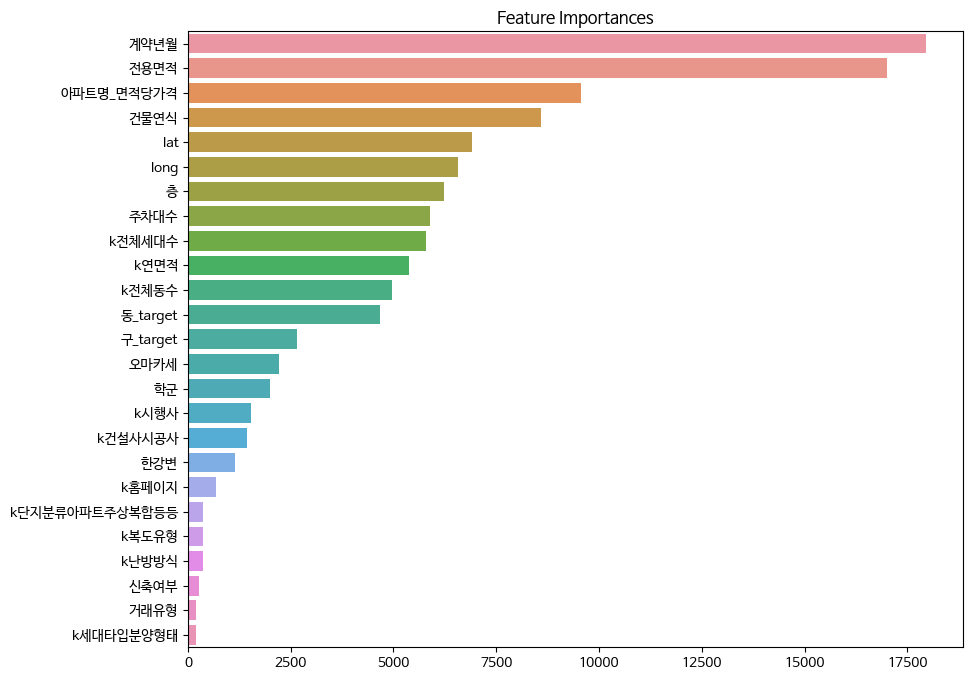

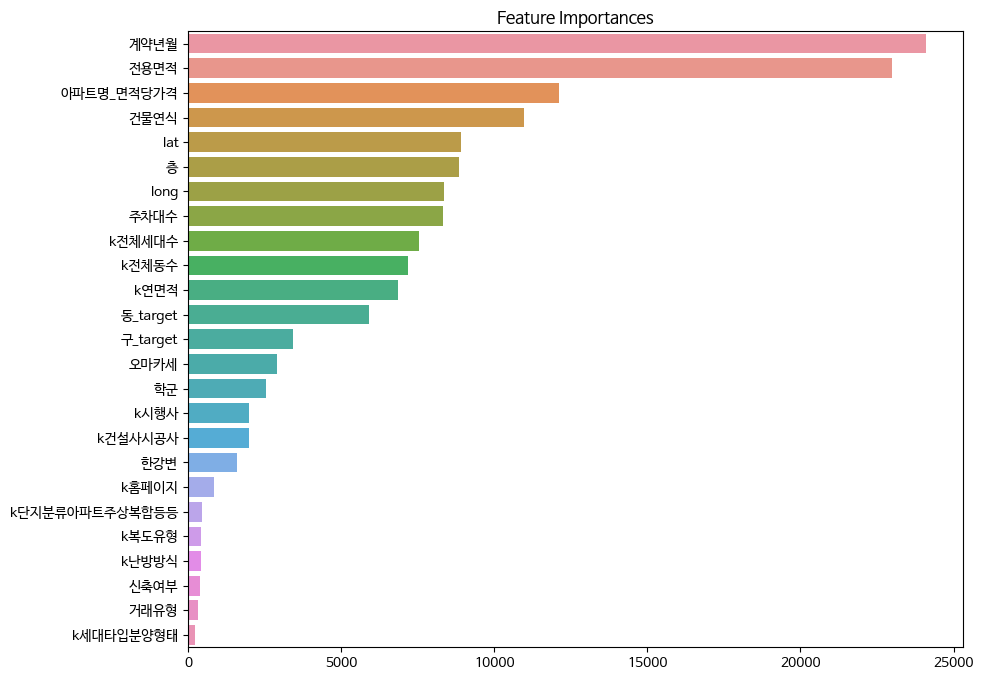

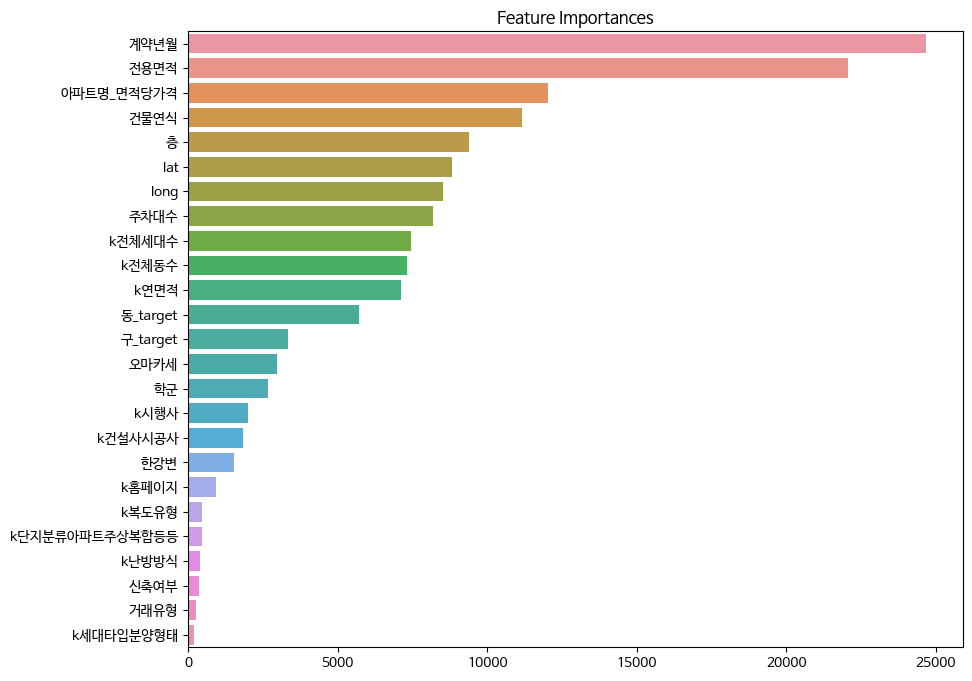

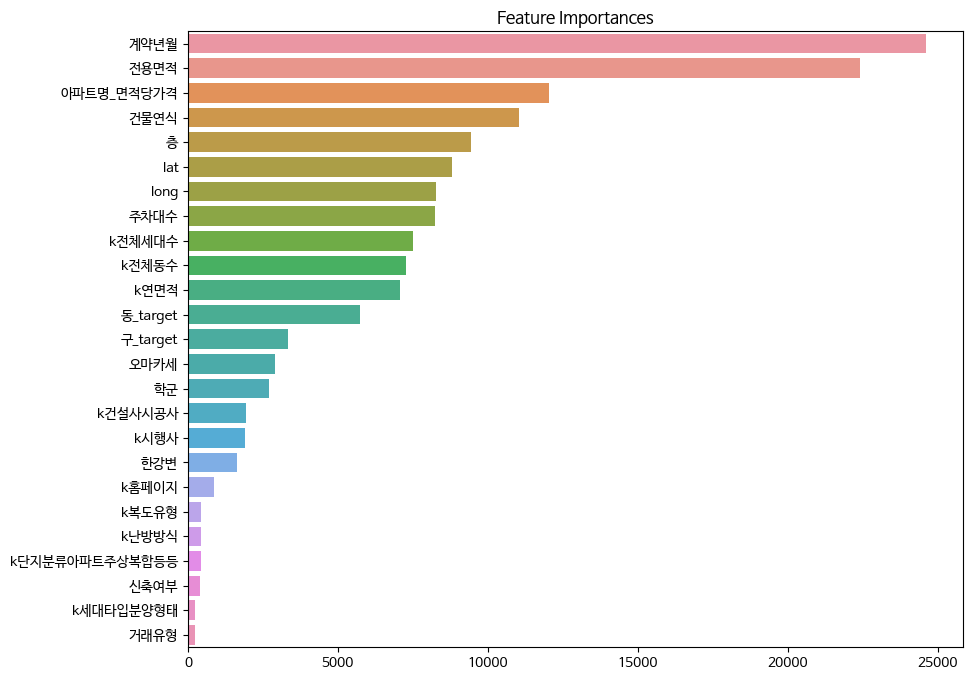

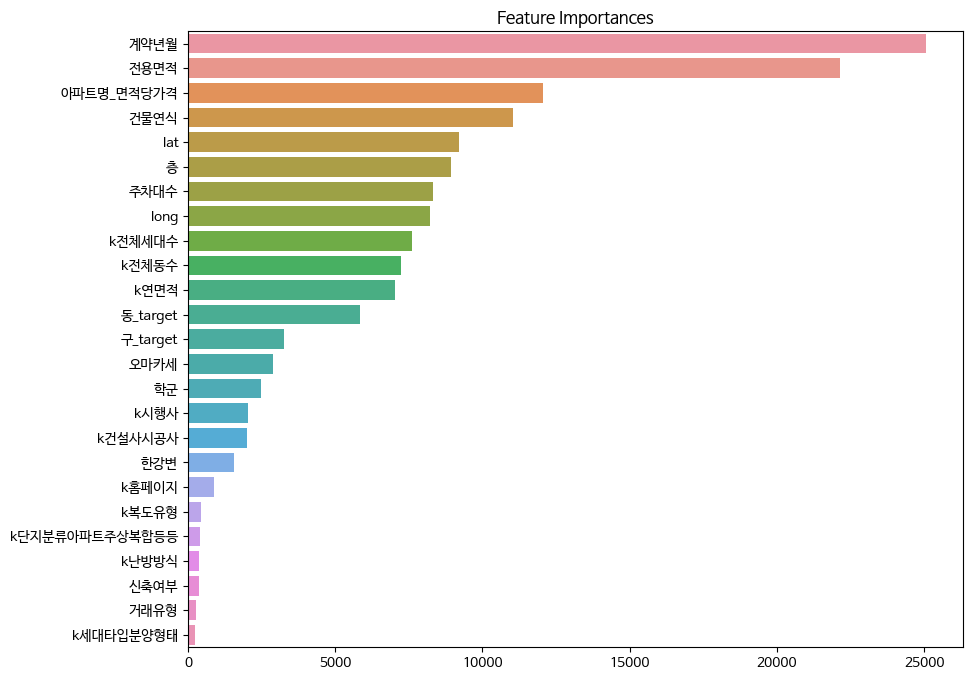

In [106]:
for model in models:
  # 위 feature importance를 시각화해봅니다.
  importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
  importances = importances.sort_values(ascending=False)

  plt.figure(figsize=(10,8))
  plt.title("Feature Importances")
  sns.barplot(x=importances, y=importances.index)
  plt.show()

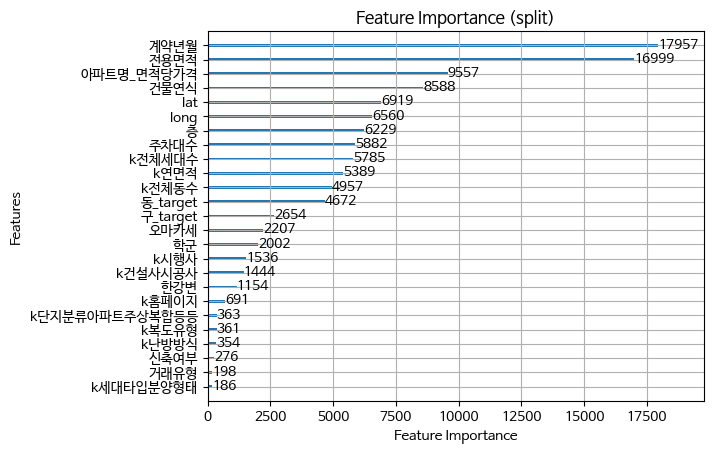

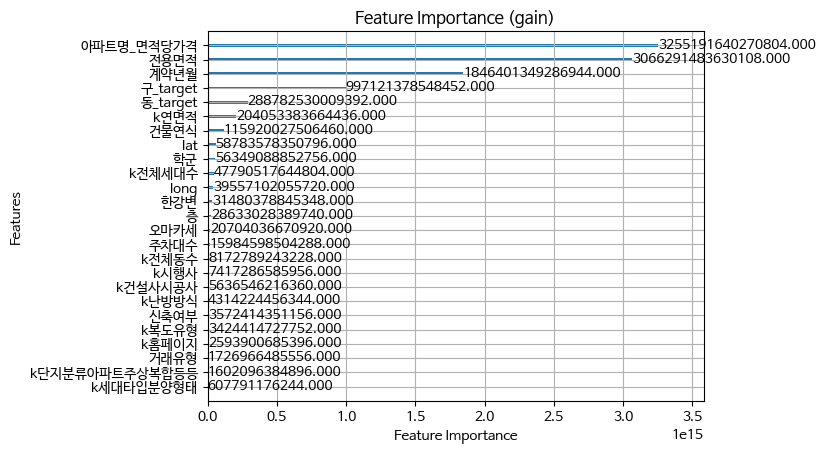

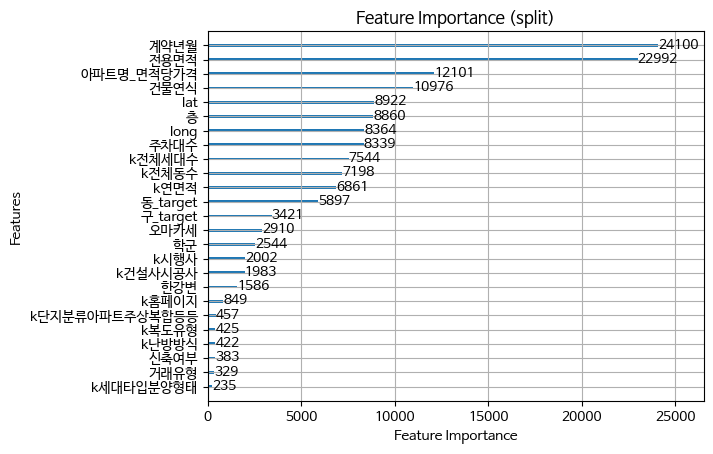

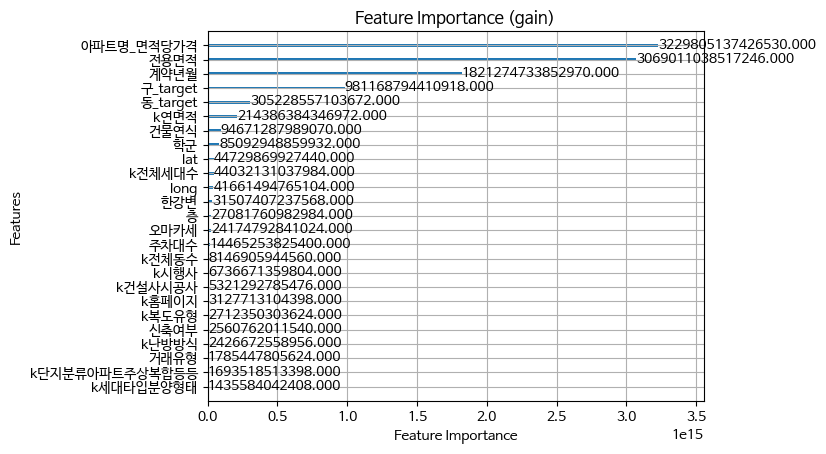

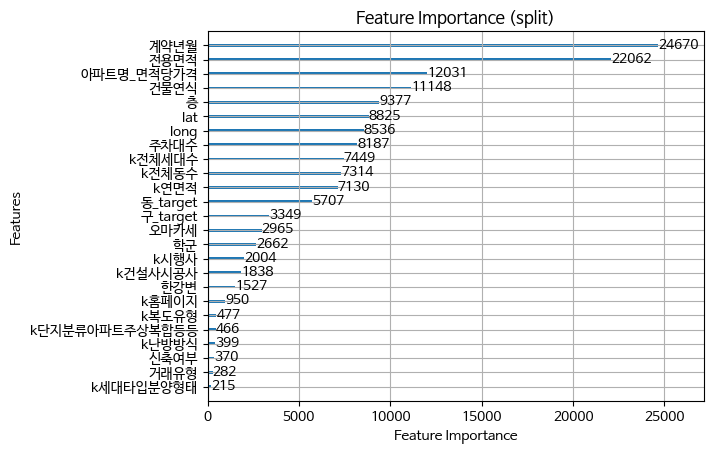

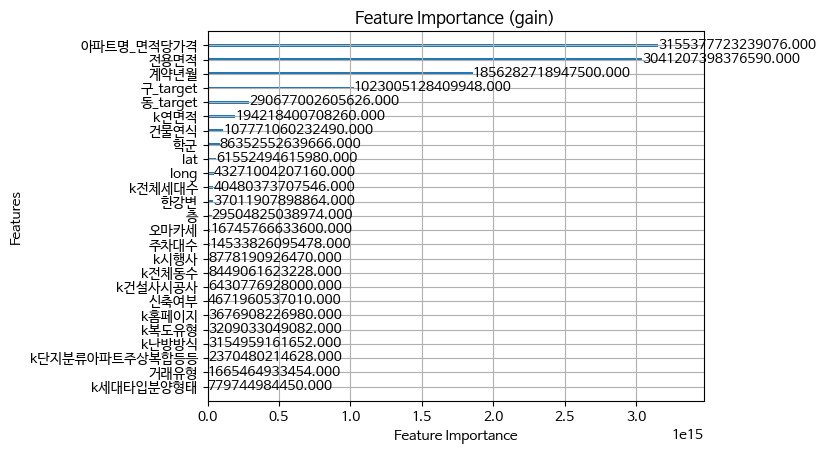

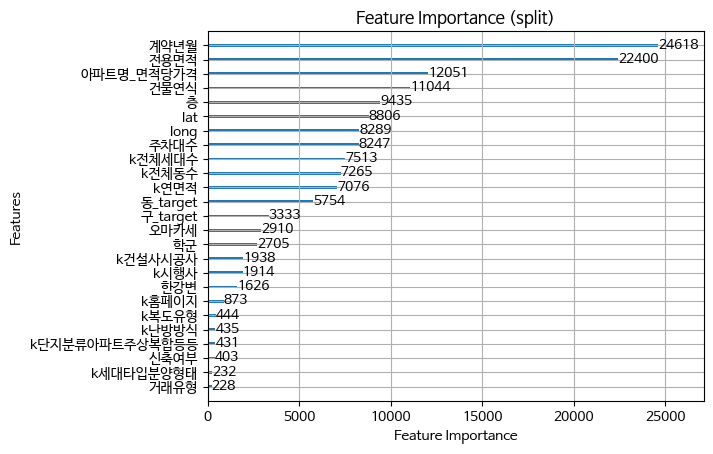

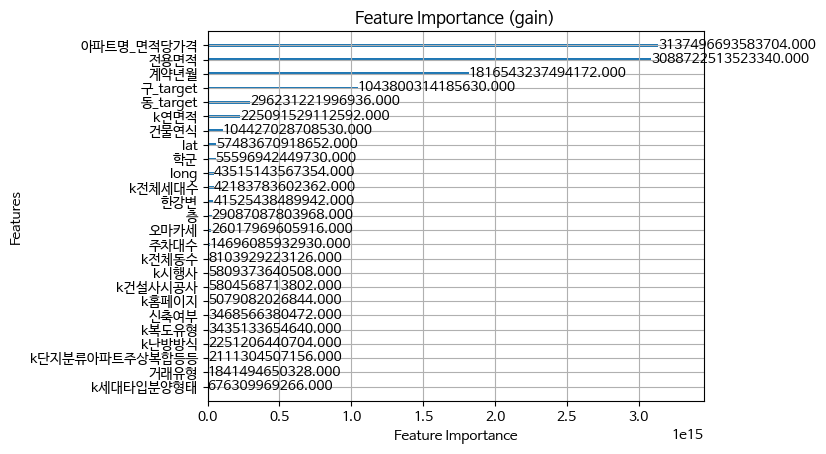

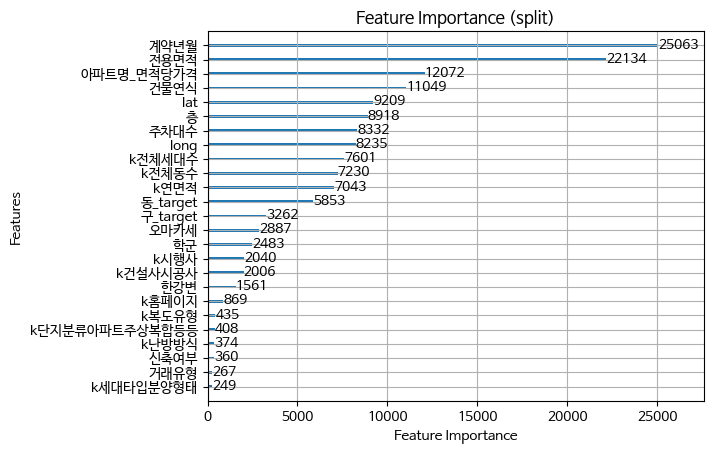

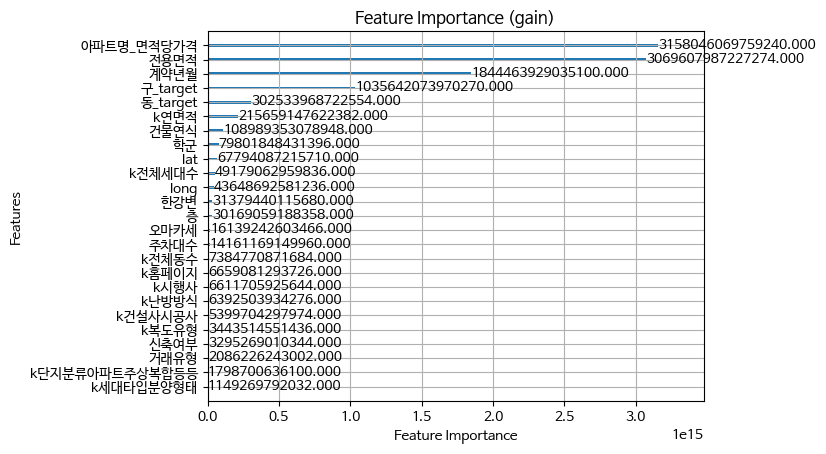

In [107]:
import lightgbm as lgb
for model in models:
  # SPLIT
  ax = lgb.plot_importance(model, max_num_features=len(df_test.columns), importance_type='split')
  ax.set(title=f'Feature Importance (split)',
    xlabel='Feature Importance',
    ylabel='Features')


  # GAIN
  ax = lgb.plot_importance(model, max_num_features=len(df_test.columns), importance_type='gain')
  ax.set(title=f'Feature Importance (gain)',
    xlabel='Feature Importance',
    ylabel='Features')

In [105]:
# model들로 test_set inference

df_train_inference, df_test_inference = target_encoding(df_train, df_test, 'target', '구')
df_train_inference, df_test_inference = dong_target_encoding(df_train_inference, df_test_inference, 'target')
df_train_inference, df_test_inference = apartment_target_encoding(df_train_inference, df_test_inference, 'target')
df_train_inference, df_test_inference = contract_encoding(df_train_inference, df_test_inference)

numeric_features = df_test_inference.select_dtypes(include=[np.number]).columns
categorical_features = df_test_inference.select_dtypes(include=[np.object]).columns

# 범주형 변수에 대한 보간
df_train_inference[categorical_features] = df_train_inference[categorical_features].fillna('NULL')
df_test_inference[categorical_features] = df_test_inference[categorical_features].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
df_train_inference[numeric_features] = df_train_inference[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
df_test_inference[numeric_features] = df_test_inference[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# 레이블 인코딩
df_train_inference, df_test_inference, label_encoders = label_encoding(df_train_inference, df_test_inference)


# 1. 각 모델의 예측값을 저장할 리스트
predictions = []

# 2. 각 모델의 예측 수행
for model in models:
    pred = model.predict(df_test_inference)
    predictions.append(pred)

# 3. 예측값들을 numpy 배열로 변환
predictions = np.array(predictions)

# 4. 앙상블 방식 선택
# 4-1. 평균 (가장 일반적인 방식)
ensemble_pred = np.mean(predictions, axis=0)
  
# df 변환
output = pd.DataFrame(ensemble_pred.astype(int), columns=["target"])
output.to_csv('./../../Datas/output.csv', index=False)


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
